---
# **Group 15**
## - **Bishal Ghosh - (23200342)** (Primary contributor to this code)
## - **Stebin Sebastian - (23200018)** (Secondary contributor to this code) 
## - **Thapanee Sasuwan - (23201498)** (Looked after the QA of the code)
## - **Ambarish Tirumalai - (23201747)** (Looked after the code comments and Markdown)
---

In [1]:
import os
import timm
from fastai.vision.all import *
import pandas as pd
from fastai.vision.all import *
from fastai.vision import models
from fastai.metrics import error_rate, accuracy

import warnings
warnings.filterwarnings("ignore")
set_seed(42)

print ('modules loaded')

modules loaded


## Data Preprocessing

Read data and store it in a dataframe

In [2]:
import os
import pandas as pd

# Get the current working directory
cd = os.getcwd()
data_dir = os.path.join(cd, 'Diseases Data', 'Leuk_data')
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
      
        rel_path = os.path.relpath(fpath, cd)
        
        filepaths.append(rel_path)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)


In [3]:
df

,filepaths,labels
0,Diseases Data/Leuk_data/Early/WBC-Malignant-Early-186.jpg,Early
1,Diseases Data/Leuk_data/Early/WBC-Malignant-Early-192.jpg,Early
2,Diseases Data/Leuk_data/Early/WBC-Malignant-Early-179.jpg,Early
3,Diseases Data/Leuk_data/Early/WBC-Malignant-Early-145.jpg,Early
4,Diseases Data/Leuk_data/Early/WBC-Malignant-Early-151.jpg,Early
...,...,...
795,Diseases Data/Leuk_data/Pre/WBC-Malignant-Pre-188.jpg,Pre
796,Diseases Data/Leuk_data/Pre/WBC-Malignant-Pre-163.jpg,Pre
797,Diseases Data/Leuk_data/Pre/WBC-Malignant-Pre-177.jpg,Pre
798,Diseases Data/Leuk_data/Pre/WBC-Malignant-Pre-017.jpg,Pre


In [6]:
dls = ImageDataLoaders.from_df(df,
                                fn_col=0, # filepaths
                                label_col=1, # labels
                                valid_pct=0.2,
                                folder='', 
                                item_tfms=Resize(64))

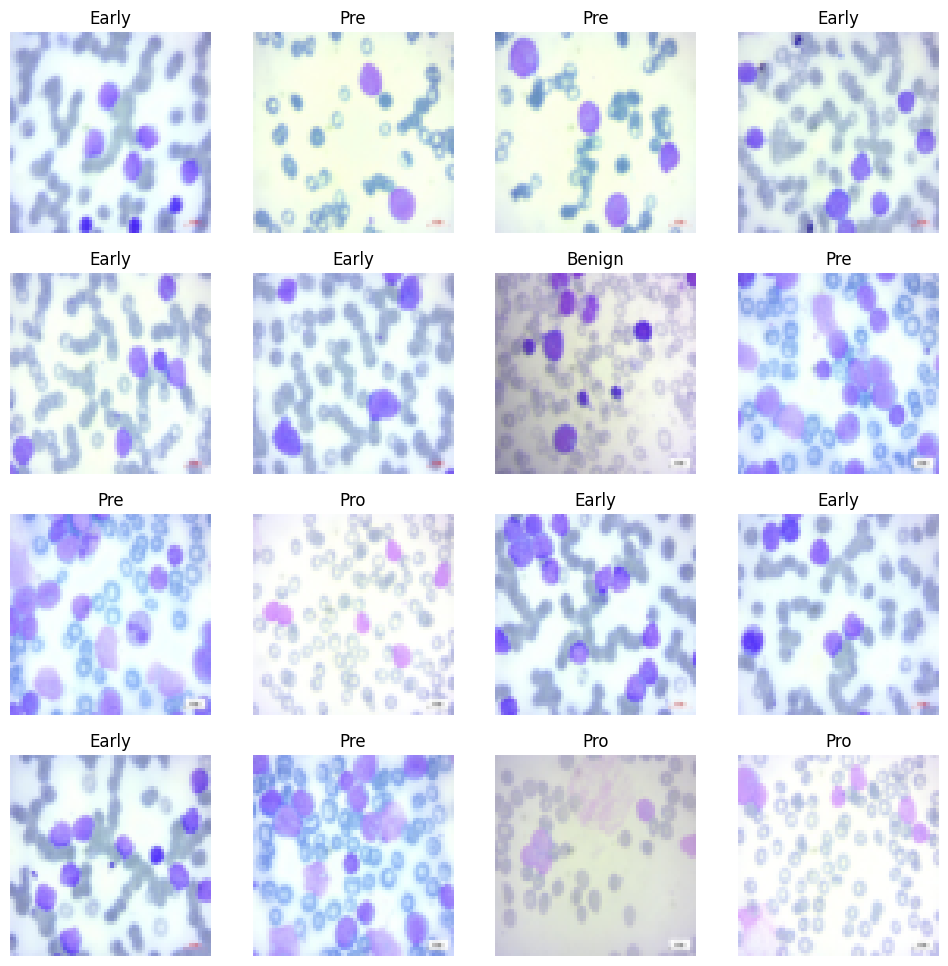

In [7]:
dls.show_batch(max_n=16)

## Model Structure

In [8]:
import timm
learn = vision_learner(dls, 'efficientnet_b3', metrics=[accuracy, error_rate], path='.').to_fp16()
learn.summary()

Sequential (Input shape: 64 x 3 x 64 x 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 40 x 32 x 32   
Conv2d                                    1080       False     
Identity                                                       
SiLU                                                           
Conv2d                                    360        False     
Identity                                                       
SiLU                                                           
____________________________________________________________________________
                     64 x 10 x 1 x 1     
Conv2d                                    410        False     
SiLU                                                           
____________________________________________________________________________
                     64 x 40 x 1 x 1     
Conv2d                                    440        False     
Sigmoid                              

SuggestedLRs(valley=0.0014454397605732083, slide=0.0008317637839354575)

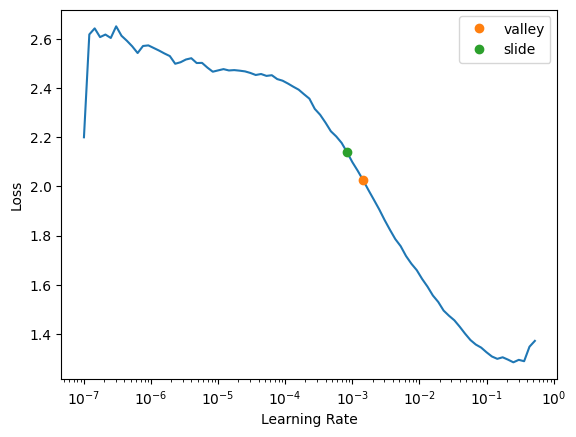

In [9]:
learn.lr_find(suggest_funcs=(valley, slide))

## Training 

In [10]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,error_rate,time


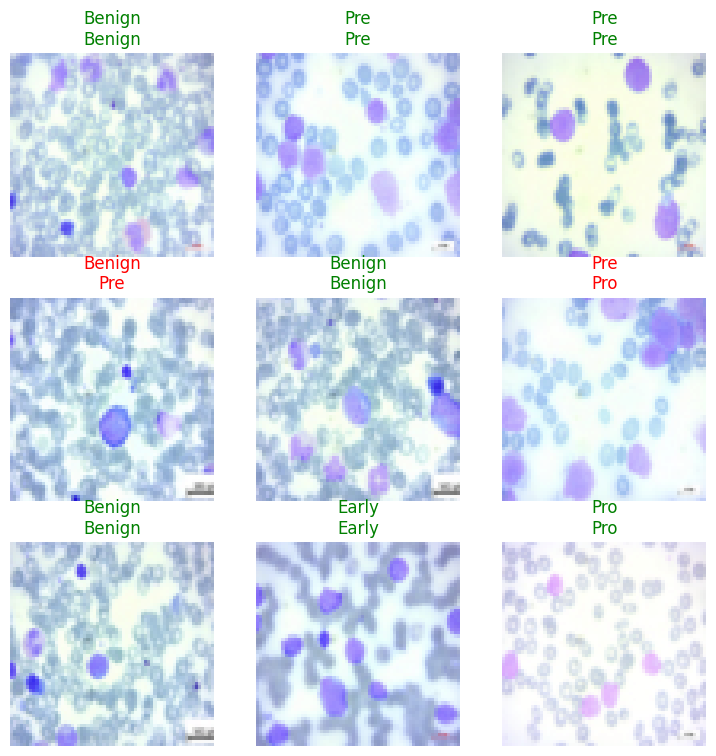

In [15]:
learn.show_results()

In [16]:
# Save the model
cd=os.getcwd()
learn.save('Diseases Data')

Path('models/Diseases Data.pth')

In [17]:

interp = ClassificationInterpretation.from_learner(learn)

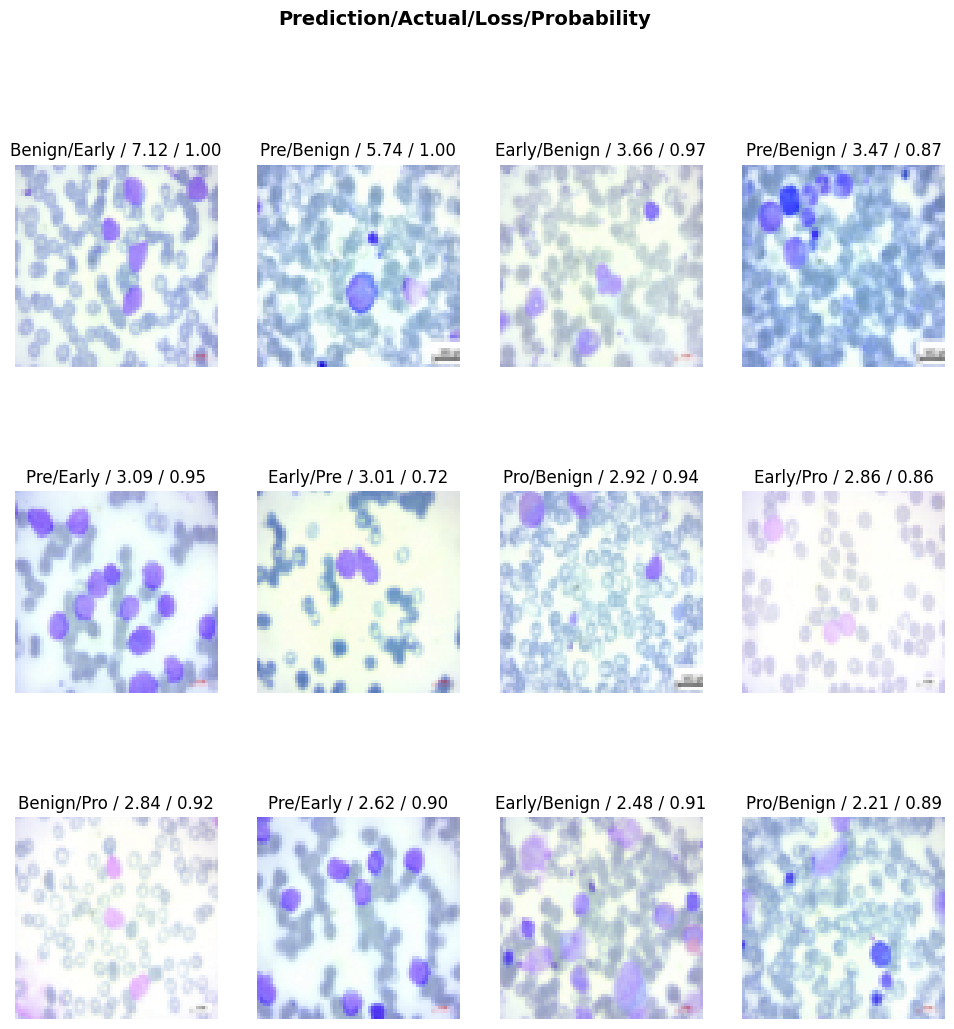

In [18]:
# Plot the top ‘n’ classes where the classifier has least precision.
interp.plot_top_losses(12, figsize=(12,12))

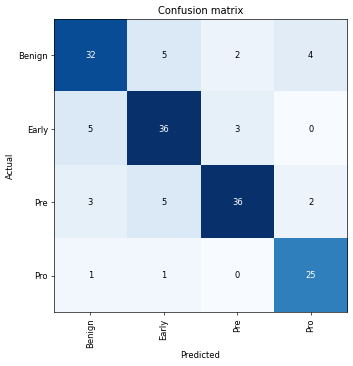

In [19]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [21]:
#To view the list of classes most misclassified as a list
interp.most_confused(min_val=2) #We are ignoring single image misclassification

#Sorted descending list of largest non-diagonal entries of confusion matrix, 
#presented as actual, predicted, number of occurrences.

[('Benign', 'Early', 5),
 ('Early', 'Benign', 5),
 ('Pre', 'Early', 5),
 ('Benign', 'Pro', 4),
 ('Early', 'Pre', 3),
 ('Pre', 'Benign', 3),
 ('Benign', 'Pre', 2),
 ('Pre', 'Pro', 2)]